In [9]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.2 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [359]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
color_pal = sns.color_palette()
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# **Reading The Data**

In [11]:
path = '/kaggle/input/microsoft-stock-time-series-analysis/Microsoft_Stock.csv'

In [143]:
data = pd.read_csv(path)

In [144]:
data.sample(5)

,Date,Open,High,Low,Close,Volume
1038,5/16/2019 16:00:00,126.75,129.38,126.46,128.93,30112216
580,7/20/2017 16:00:00,74.18,74.30,73.28,74.22,42361025
1028,5/2/2019 16:00:00,127.98,128.00,125.52,126.21,27350161
1507,3/26/2021 16:00:00,231.55,236.71,231.55,236.48,25479853
233,3/4/2016 16:00:00,52.40,52.45,51.71,52.03,33034150


In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1511 non-null   object 
 1   Open    1511 non-null   float64
 2   High    1511 non-null   float64
 3   Low     1511 non-null   float64
 4   Close   1511 non-null   float64
 5   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 71.0+ KB


# **Convert type of column {Date} to datetype**

In [146]:
data['Date'] = pd.to_datetime(data.Date)

# **Make Column Date as Index**

In [147]:
data = data.set_index('Date')

In [148]:
data.sample(5)

,Open,High,Low,Close,Volume
Date,,,,,
2021-02-25 16:00:00,232.08,234.59,227.88,228.99,39542235
2016-10-07 16:00:00,57.85,57.98,57.42,57.80,20089020
2016-10-21 16:00:00,60.28,60.45,59.49,59.66,80032206
2020-10-15 16:00:00,217.10,220.36,216.01,219.66,22733064
2015-11-04 16:00:00,54.18,54.88,54.06,54.40,37087849


# **Simple of Feature Engineering**

In [149]:
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour

In [210]:
data['quarter'] = data.index.quarter

In [211]:
data.sample(5)

,Open,High,Low,Close,Volume,year,month,day,hour,quarter
Date,,,,,,,,,,
2016-06-30 16:00:00,50.72,51.30,50.50,51.17,28527781,2016,6,30,16,2
2017-11-28 16:00:00,84.07,85.06,84.02,84.88,21925959,2017,11,28,16,4
2015-09-17 16:00:00,44.29,45.00,44.08,44.25,32768161,2015,9,17,16,3
2017-08-25 16:00:00,72.86,73.35,72.48,72.82,12794301,2017,8,25,16,3
2019-01-31 16:00:00,103.80,105.22,103.18,104.43,55636391,2019,1,31,16,1


In [151]:
start_date = data.index.min()
last_date = data.index.max()

# **Get data by year for visualization it**

In [168]:
def get_data_by_year(data, year):
    df = data[data['year'] == year]
    return df

In [169]:
set(data.year.values)

{2015, 2016, 2017, 2018, 2019, 2020, 2021}

In [170]:
df_2015 = get_data_by_year(data, 2015)
df_2016 = get_data_by_year(data, 2016)
df_2017 = get_data_by_year(data, 2017)
df_2018 = get_data_by_year(data, 2018)
df_2019 = get_data_by_year(data, 2019)
df_2020 = get_data_by_year(data, 2020)
df_2021 = get_data_by_year(data, 2021)

# **Visualization Data**

**Volume by all years**

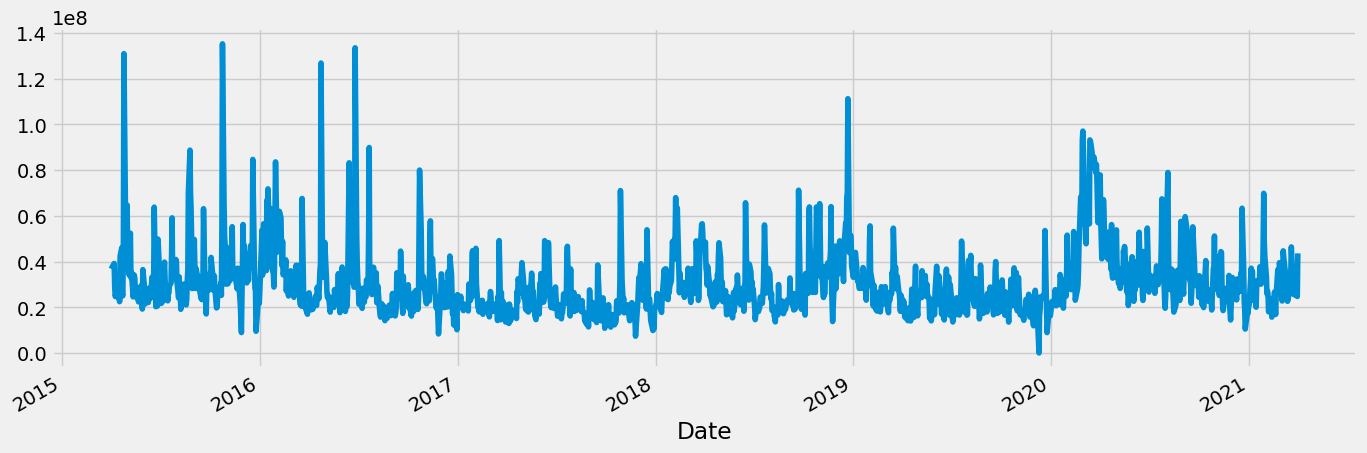

In [212]:
data['Volume'].plot(figsize=(15,5))
plt.show()

**Open by all years**

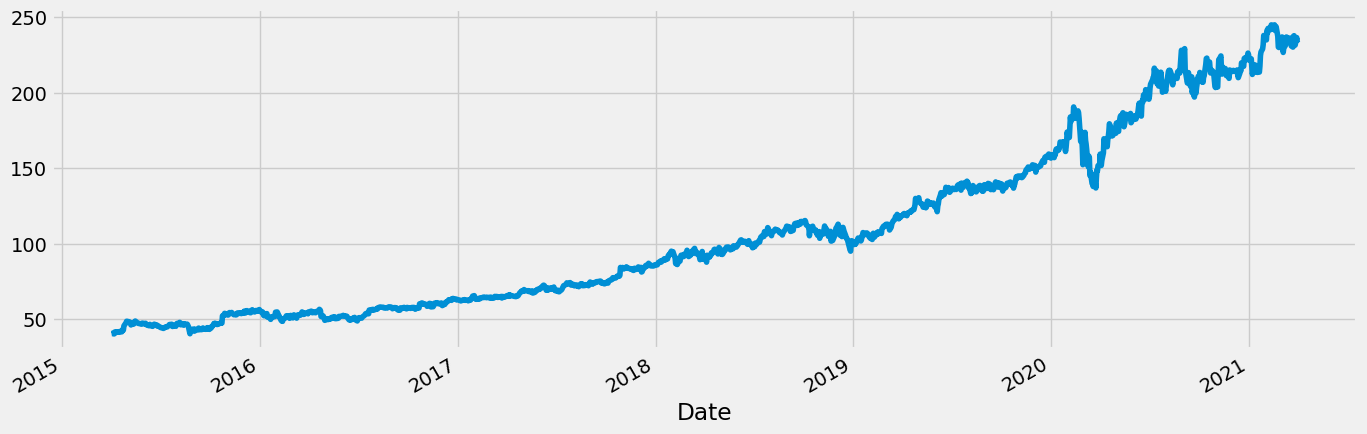

In [213]:
data['Open'].plot(figsize=(15,5))
plt.show()

**Close by all years**

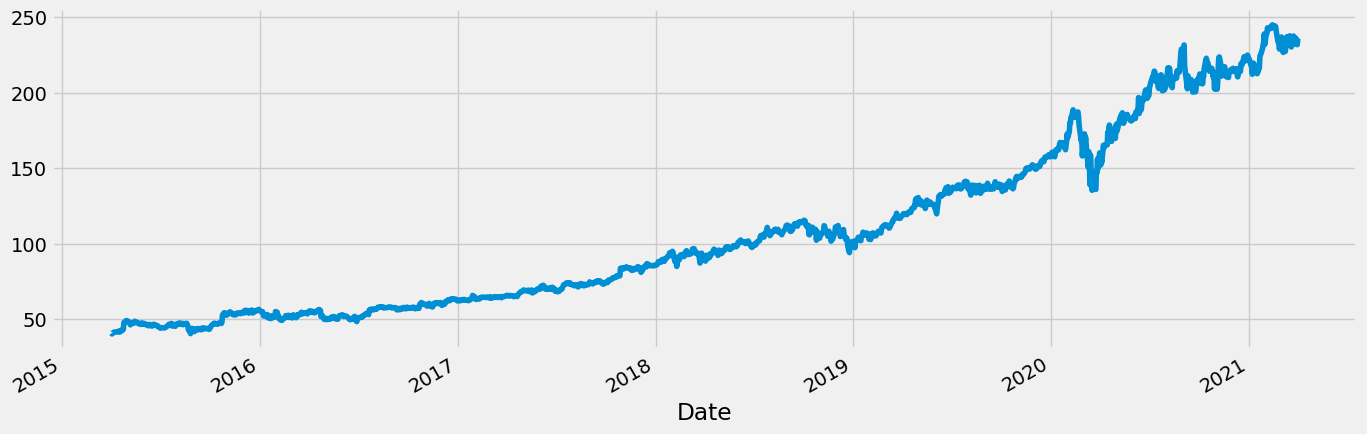

In [114]:
data['Close'].plot(figsize=(15,5))
plt.show()

**High by all years**

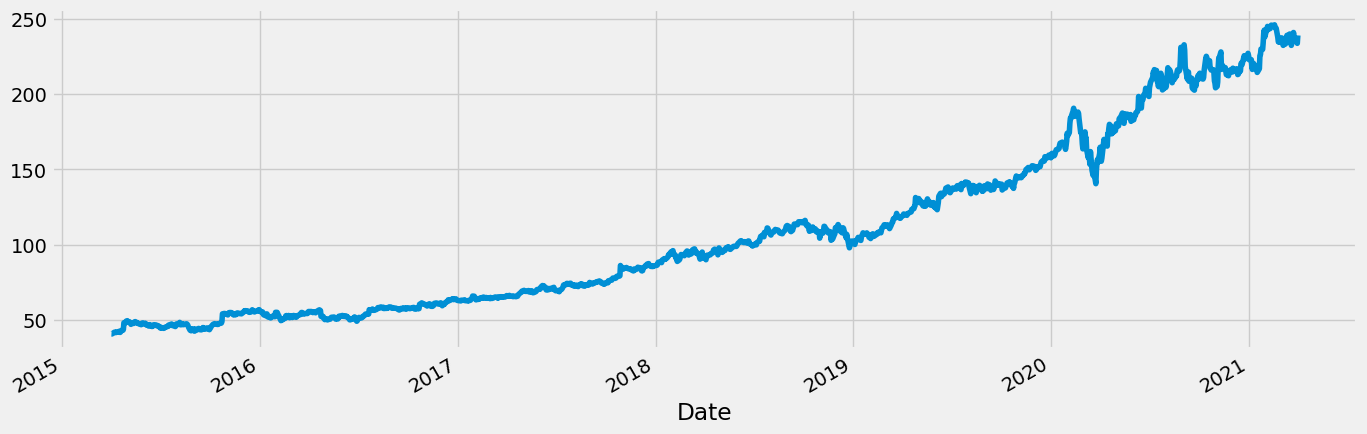

In [115]:
data['High'].plot(figsize=(15,5))
plt.show()

**Low by all years**

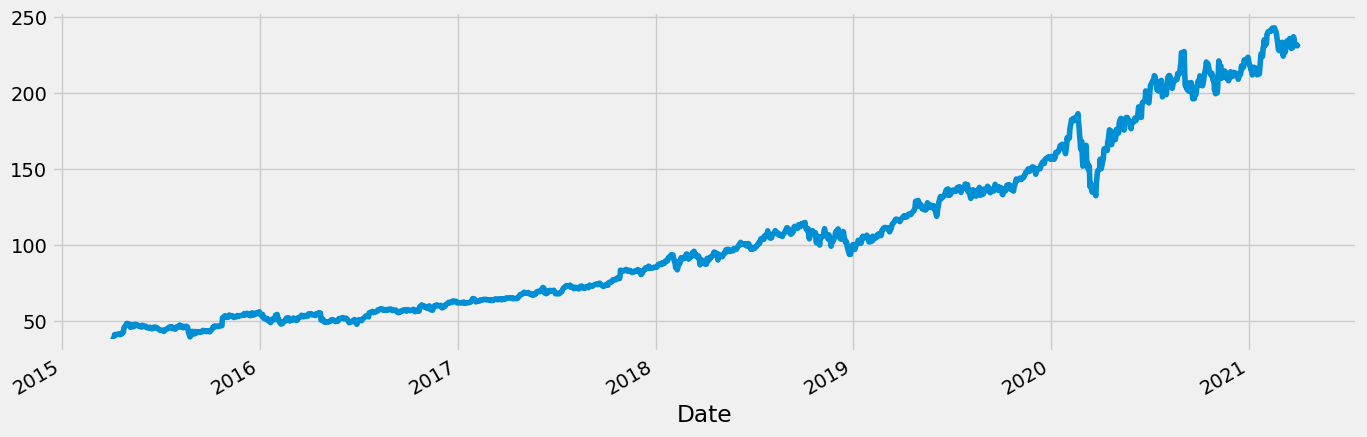

In [116]:
data['Low'].plot(figsize=(15,5))
plt.show()

**Volume by every month in every year**

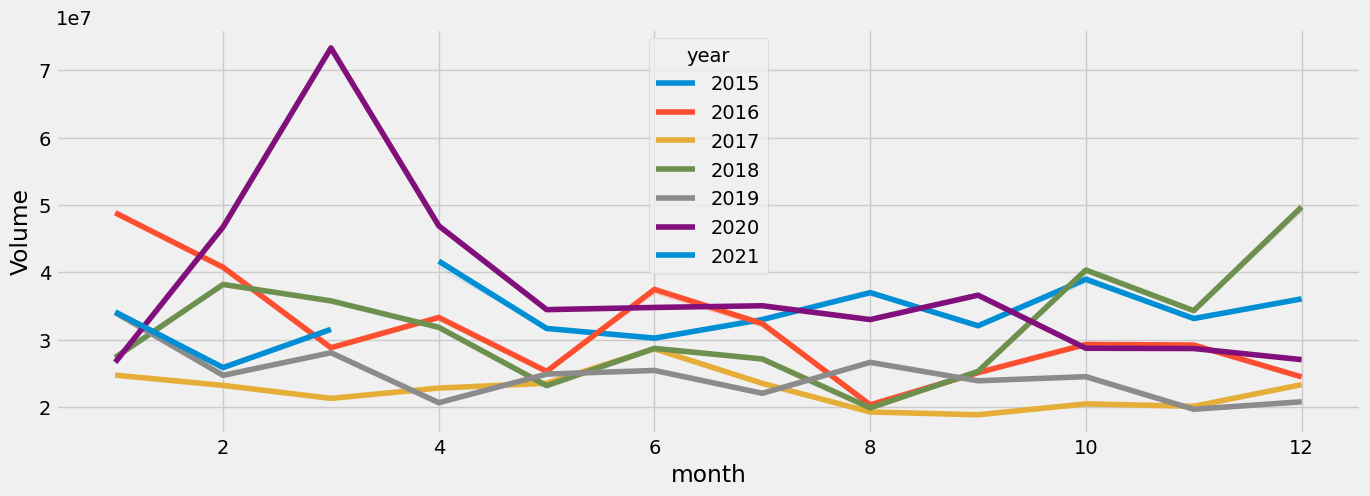

In [120]:
plt.subplots(figsize=(15, 5))
sns.lineplot(data=data, x='month', y='Volume', hue='year',palette=color_pal, ci=False)
plt.show()

**as we can see from above plot so lets see the data with high volume in 2020**

In [174]:
data_high_volume_2020 = df_2020.loc[(df_2020.index>'2020-01-01') & (df_2020.index<'2020-04-01')]

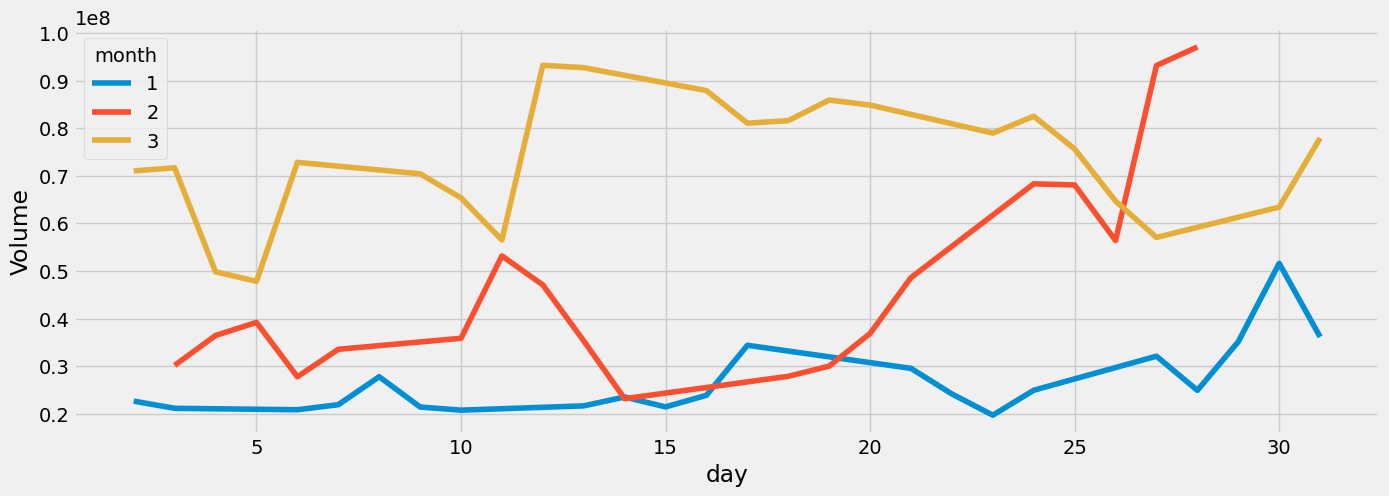

In [175]:
plt.subplots(figsize=(15, 5))
sns.lineplot(data=data_high_volume_2020, x='day', y='Volume', hue='month',palette=color_pal, ci=False)
plt.show()

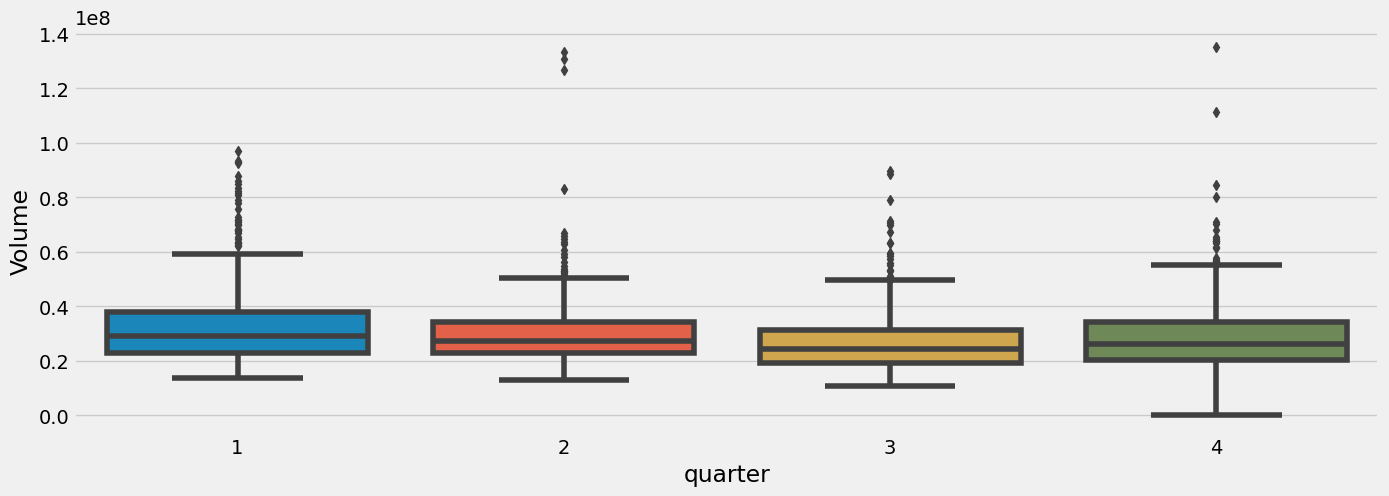

In [217]:
plt.subplots(figsize=(15, 5))
sns.boxplot(data=data, x='quarter', y='Volume',palette=color_pal)
plt.show()

**You can try any plot as you like and dive into the data 😀**

# **See if the data is stationary or not**

In [176]:
def is_stationary(columnName):
    res = adfuller(columnName)
    if res[1] < 0.05:
        print('the data of {} is stationary series'.format(columnName.name))
    else:
        print('the data of {} is not stationary series'.format(columnName.name))

In [23]:
is_stationary(data.Volume)

the data of Volume is stationary series


In [26]:
is_stationary(data.Open)

the data of Open is not stationary series


In [27]:
is_stationary(data.Close)

the data of Close is not stationary series


In [28]:
is_stationary(data.High)

the data of High is not stationary series


In [29]:
is_stationary(data.Low)

the data of Low is not stationary series


# **Convert all data that is not stationary to stationary data**

**convert it day by day**

In [180]:
df_open_diff = data.Open - data.Open.shift(freq='D')
df_open_diff = df_open_diff.dropna()

df_close_diff = data.Close - data.Close.shift(freq='D')
df_close_diff = df_close_diff.dropna()

df_high_diff = data.High - data.High.shift(freq='D')
df_high_diff = df_high_diff.dropna()

df_low_diff = data.Low - data.Low.shift(freq='D')
df_low_diff = df_low_diff.dropna()

In [183]:
is_stationary(df_open_diff)
is_stationary(df_close_diff)
is_stationary(df_high_diff)
is_stationary(df_low_diff)

the data of Open is stationary series
the data of Close is stationary series
the data of High is stationary series
the data of Low is stationary series


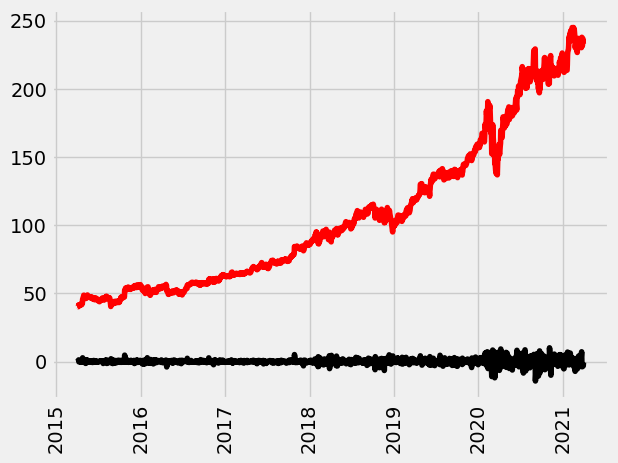

In [190]:
plt.plot(data.Open, color = "red",label = "Original")
plt.plot(df_open_diff, color='black', label = "deff shiffting")
plt.xticks(rotation=90)
plt.show()

# **Using ACF to know Stationary or not**

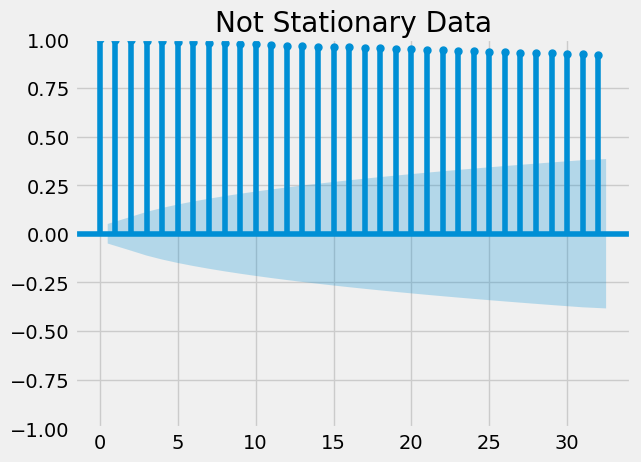

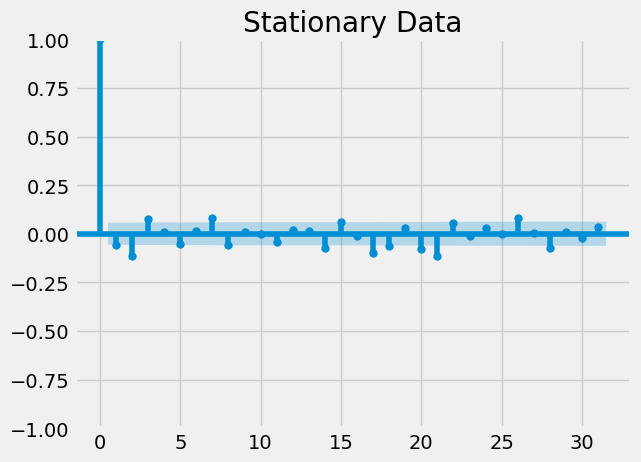

In [189]:
plot_acf(data.Open)
plt.title('Not Stationary Data')
plt.show()
plot_acf(df_open_diff)
plt.title('Stationary Data')
plt.show()

**ok it is fine! 😀**

In [220]:
data_stationary = pd.concat([df_open_diff, df_close_diff, df_high_diff, df_low_diff, data.Volume], axis=1)
data_stationary = data_stationary.dropna()

In [224]:
data_stationary.sample(5)

,Open,Close,High,Low,Volume
Date,,,,,
2020-10-27 16:00:00,-2.26,3.17,-1.67,2.23,36700325
2016-06-01 16:00:00,0.18,-0.15,-0.05,0.36,25324828
2017-04-06 16:00:00,-0.70,0.17,-0.29,0.04,18103453
2020-04-16 16:00:00,3.10,5.16,3.71,3.66,50479610
2016-05-20 16:00:00,0.01,0.30,0.60,0.58,23905769


# **ARIMA Model**

# **Using auto_arima to get best hyperparameters for ARIMA Model**

In [339]:
test_arima = auto_arima(df_close_diff, trace=True, suppers_warnings=True)
test_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5182.907, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5238.707, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5195.489, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5186.766, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5240.632, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5181.301, Time=0.90 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=5184.692, Time=0.41 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5185.093, Time=0.30 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=5182.988, Time=2.00 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=5186.369, Time=0.44 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5186.675, Time=0.39 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=5173.948, Time=3.95 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=5175.641, Time=4.72 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=5175.588, Time=5.03 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1179
Model:               SARIMAX(2, 0, 3)   Log Likelihood               -2579.974
Date:                Tue, 07 May 2024   AIC                           5173.948
Time:                        01:24:07   BIC                           5209.455
Sample:                             0   HQIC                          5187.335
                               - 1179                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0236      0.007      3.440      0.001       0.010       0.037
ar.L1          0.0558      0.057      0.981      0.327      -0.056       0.167
ar.L2          0.7611      0.042     18.042      0.000       0.678       0.844
ma.L1         -0.2731      0.057     -4.815      0.000      -0.384      -0.162
ma.L2         -0.8336      0.043    -19.541      0.000      -0.917      -0.750
ma.L3          0.1835      0.021      8.900      0.000       0.143       0.224
sigma2         4.6577      0.084     55.429      0.000       4.493       4.822
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              5801.17
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              16.19   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**ARIMA(2,0,3)**

# **Split Data**

In [340]:
train = df_close_diff.loc[df_close_diff.index < '01-01-2020'] 
test = df_close_diff.loc[df_close_diff.index >= '01-01-2020'] 

In [341]:
train.shape

(933,)

In [342]:
test.shape

(246,)

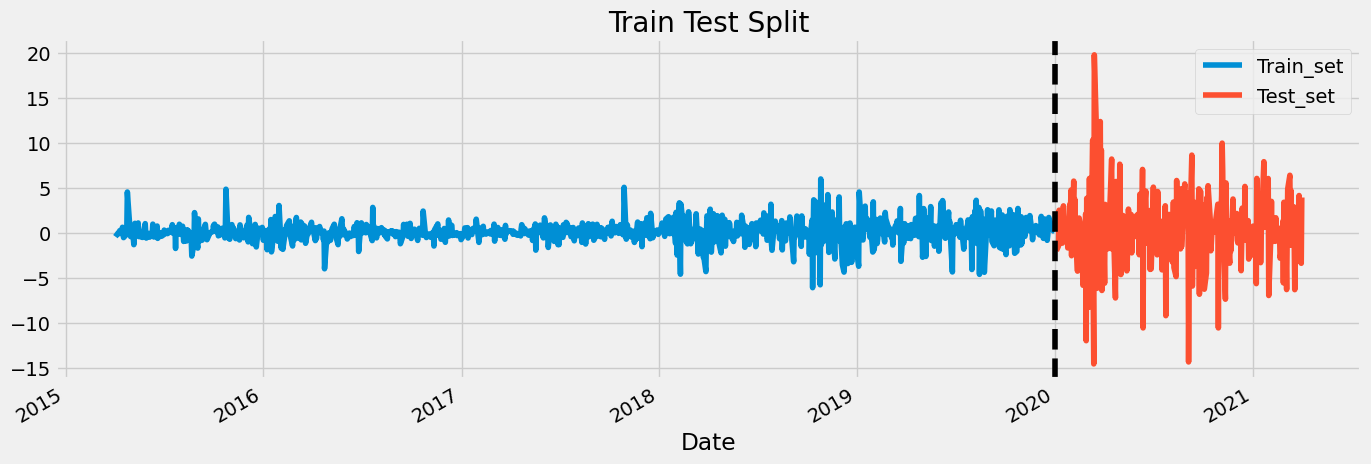

In [344]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax)
test.plot(ax=ax)
ax.axvline('01-01-2020', color ='Black', ls='--')
plt.legend(['Train_set', 'Test_set'])
plt.title('Train Test Split')
plt.show()

# **Fitting the Model and get the Prediction**

In [345]:
model = sm.tsa.arima.ARIMA(train, order=(2,0,3))
model_fit = model.fit()

In [346]:
start = len(train)
end = len(train) + len(test) - 1

In [377]:
forecast = model_fit.predict(start=start, end=end)
forecast.index = df_close_diff.index[start:end+1]
forecast

Date
2020-01-03 16:00:00   -0.025083
2020-01-07 16:00:00   -0.038878
2020-01-08 16:00:00    0.047546
2020-01-09 16:00:00    0.025720
2020-01-10 16:00:00    0.077554
                         ...   
2021-03-24 16:00:00    0.109872
2021-03-25 16:00:00    0.109872
2021-03-26 16:00:00    0.109872
2021-03-30 16:00:00    0.109872
2021-03-31 16:00:00    0.109872
Name: predicted_mean, Length: 246, dtype: float64

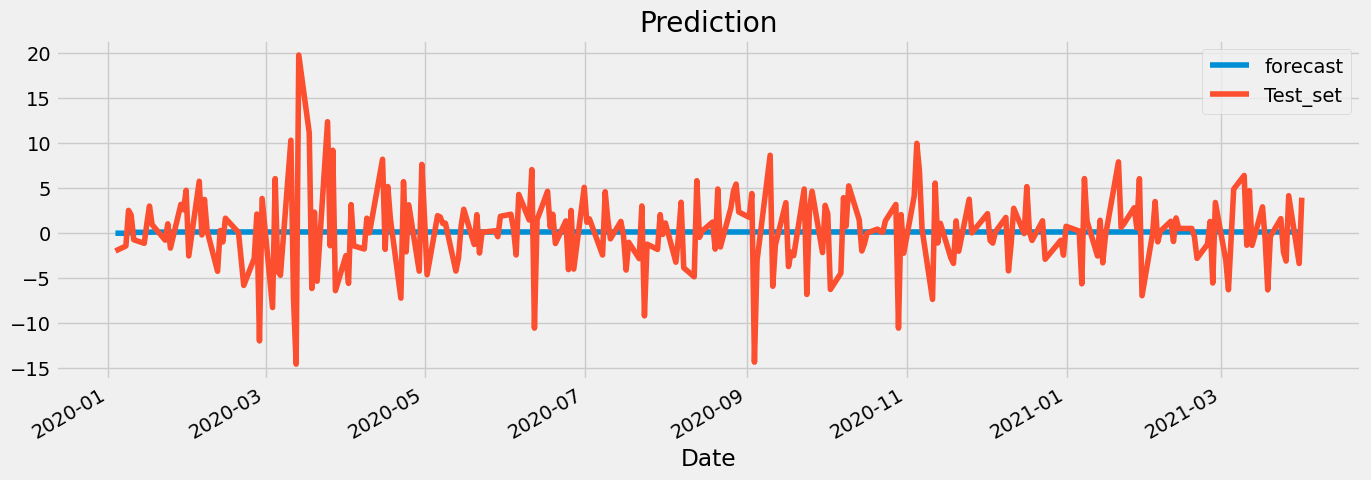

In [349]:
fig, ax = plt.subplots(figsize=(15, 5))
forecast.plot(ax=ax)
test.plot(ax=ax)
plt.legend(['forecast', 'Test_set'])
plt.title('Prediction')
plt.show()

# **XGBoosting Model**

**split data**

In [352]:
train_xg = data_stationary.loc[data_stationary.index < '01-01-2020'] 
test_xg = data_stationary.loc[data_stationary.index >= '01-01-2020'] 

In [353]:
x_train = train_xg.drop('Close', axis=1)
y_train = train_xg['Close']
x_test = test_xg.drop('Close', axis=1)
y_test = test_xg['Close']

In [354]:
model_xg = XGBRegressor(n_estimators = 100)

In [355]:
model_xg.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

**Accuracy of training**

In [356]:
model_xg.score(x_train, y_train)

0.9978078149326677

In [358]:
prediction_xg = model_xg.predict(x_test)

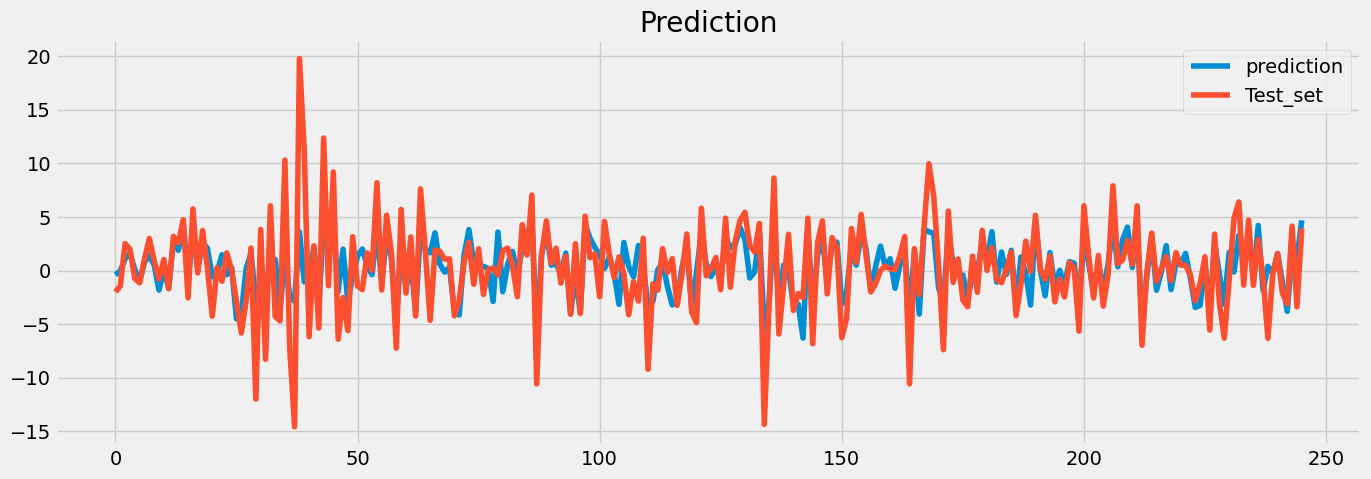

In [373]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(prediction_xg)
plt.plot(y_test.values)
plt.legend(['prediction', 'Test_set'])
plt.title('Prediction')
plt.show()

** Root Mean Square Error**

In [361]:
np.square(mean_squared_error(prediction_xg, y_test))

83.28841138465579

**ok as we can see the model give us good prediction 😄**